# ECON autoencoder loss analysis
This notebook aims to show the effect of the hyperparameters on the ECON model which could be hide to the user due to the approximation of the EMD metrics.

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
from torch.utils.data import DataLoader
import torchinfo
import numpy as np
import pandas as pd
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA
from neural_efficiency import NeuralEfficiency


# import modules from common benchmarks
module_path = os.path.abspath(os.path.join('../../workspace/common/benchmarks/')) # or the path to your source code
sys.path.insert(0, module_path)
from noisy_dataset import NoisyDataset



DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

/opt/conda/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Utility methods

In [5]:
def get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size, num_tests=3):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    EMDs = []
    min_emd = 1000
    min_emd_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'ECON_{precision}b/{size}/{size}_emd_{i}.txt'
        try:
            emd_file = open(file_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            EMDs.append(emd)
            if min_emd >= emd:
                min_emd = emd
                min_emd_index = i
            emd_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(EMDs) == 0:
        warnings.warn(f"Attention: There is no EMD value for the model: " \
                      f"bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}")
        #TODO: I may compute if the model is there
        return
    
    return mean(EMDs), min_emd_index


def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Reds',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, cmap=cmap, annot=show_value, fmt=".2f", vmin=min_max[0], vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()


def load_model(batch_size, learning_rate, precision, size):
    '''
    Method used to get the model and the relative EMD value
    '''
    emd, idx = get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_{idx}_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, emd


def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = AutoEncoderDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

def get_noise_dataloader(batch_size, dataloader, num_workers=12, percentage=5, noise_type='random'):
    noisy_dataset = NoisyDataset(dataloader, 
                                 percentage, 
                                 noise_type)
    return DataLoader(noisy_dataset, 
                      shuffle=False,
                      num_workers=num_workers,
                      batch_size=batch_size)



# EMD distance results

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
size = 'baseline'

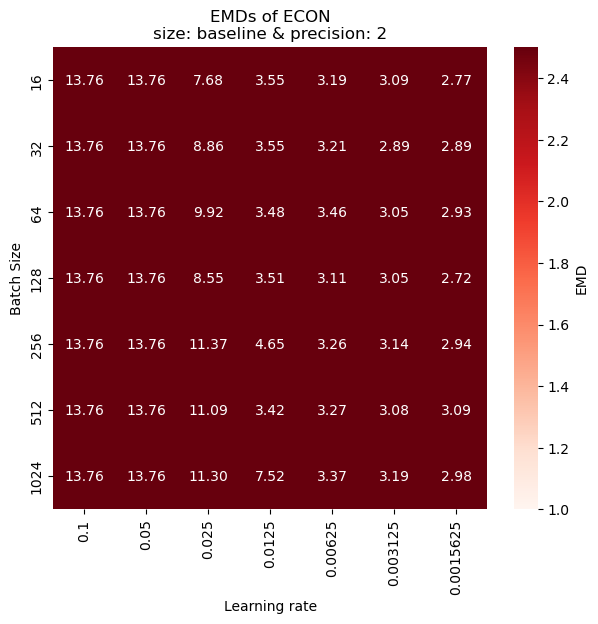

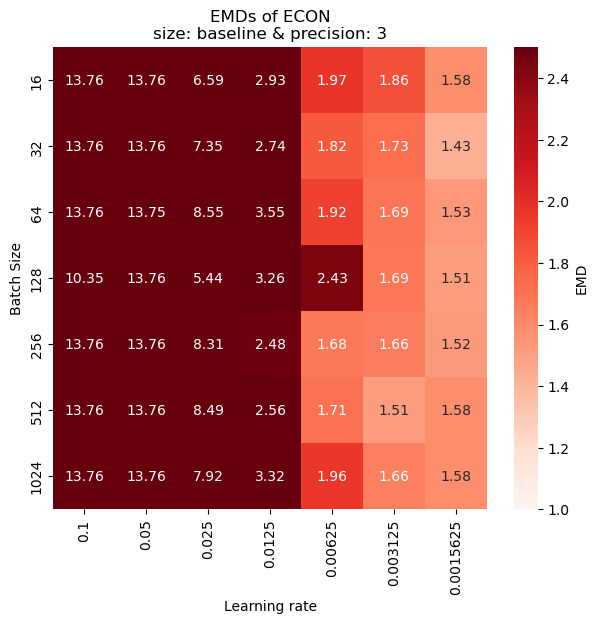

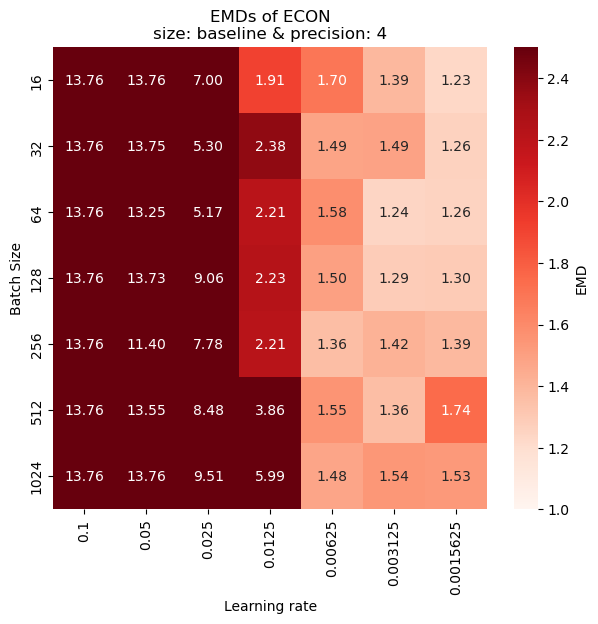

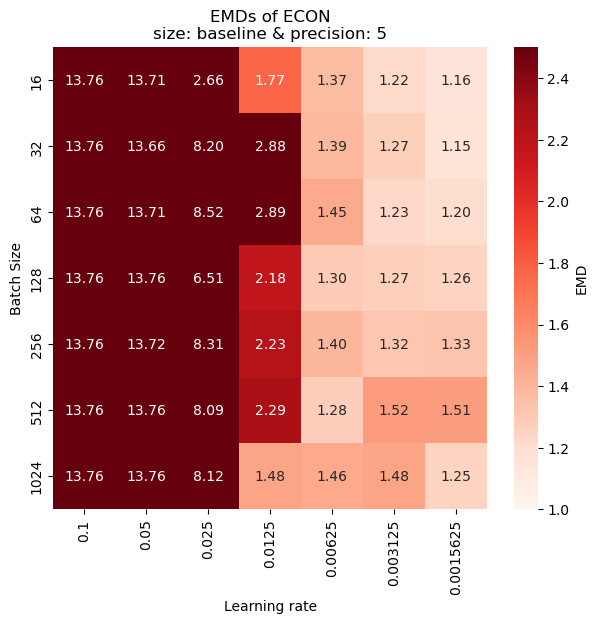

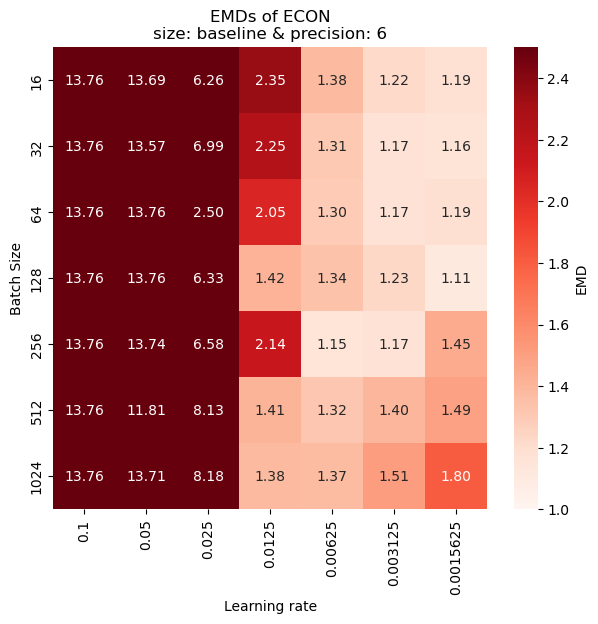

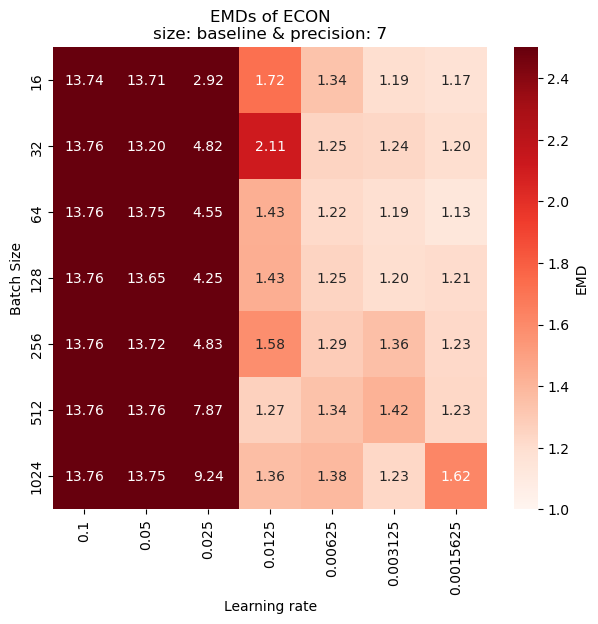

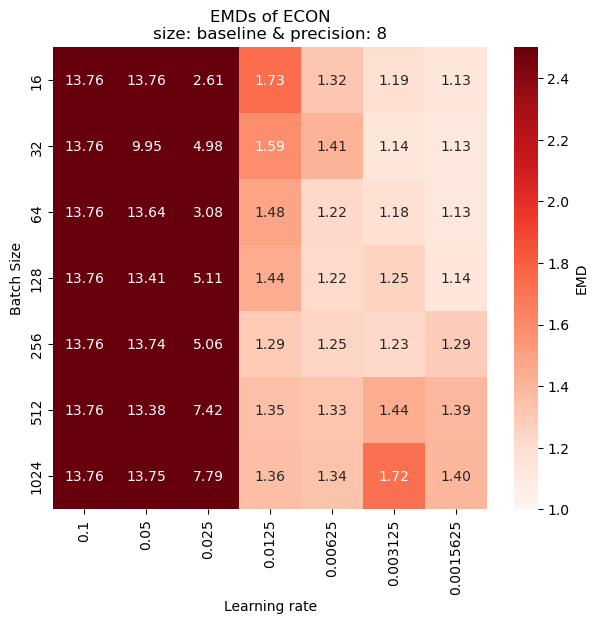

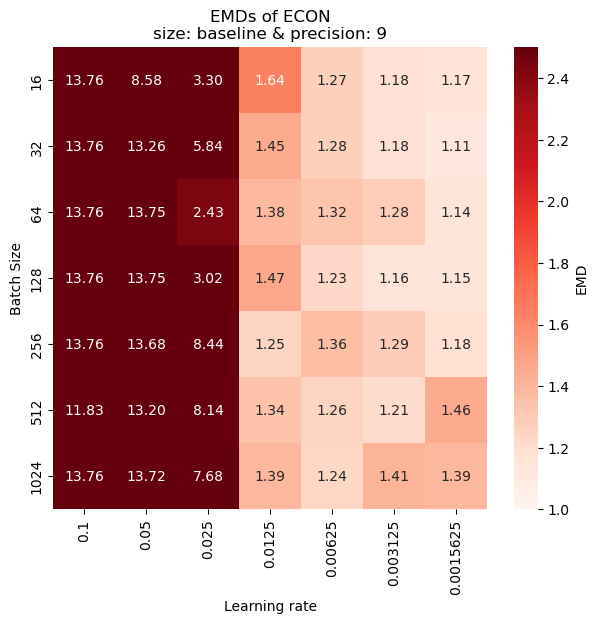

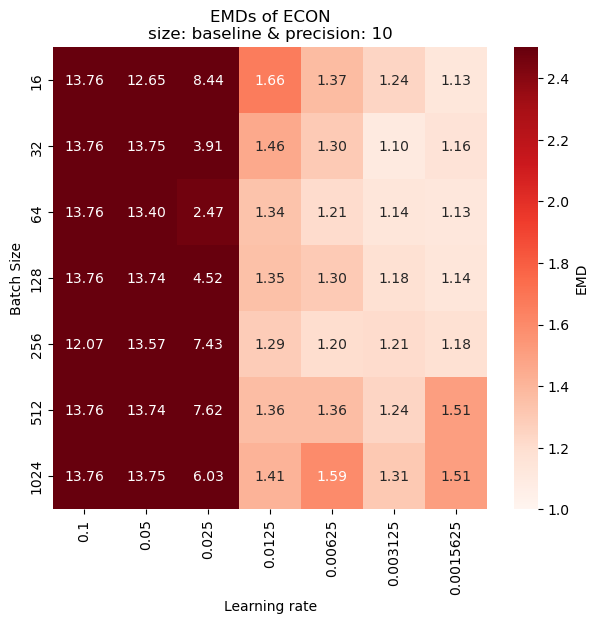

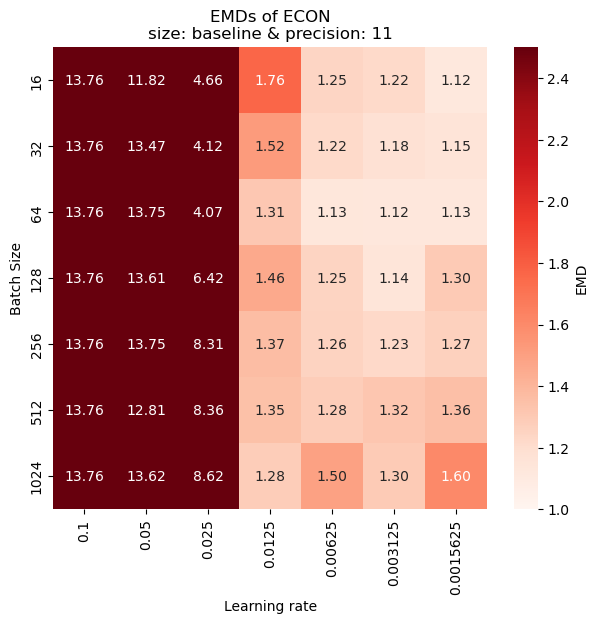

In [6]:
%matplotlib inline

#TODO: 3d heatmap and add noise

# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
    


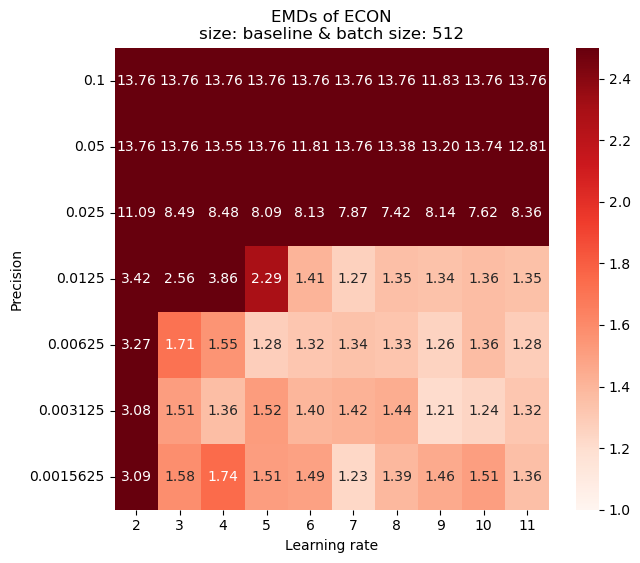

In [ ]:
%matplotlib inline

batch_size = 512
EMD_matrix = np.zeros((len(learning_rates), len(precisions)))
# EMD_matrix = np.zeros((len(precisions), len(learning_rates)))
# plotting a heat map per layer
for y, p in enumerate(precisions):
    for x, lr in enumerate(learning_rates):
        mean_EMD, _ = get_model_index_and_relative_EMD(batch_size, lr, p, size)
        EMD_matrix[x, y] = mean_EMD
            
            
EMD_matrix = pd.DataFrame(EMD_matrix, 
                        index=learning_rates, 
                        columns=precisions)

plot_2d_heatmap(EMD_matrix, 
                f'EMDs of ECON\nsize: {size} & batch size: {batch_size}', 
                (1, 2.5),
                'Learning rate',
                'Precision',
                'EMD')

We want to focus only with models with good performances so we cut out from the analysis the high learning rates.

In [13]:
learning_rates = [0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
# plotting a heat map per layer
top_models_count = 2
best_models = {}
worst_models = {}
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({'precision': p, 'EMD': mean_EMD})

    # store best and worst models
    sorted_indices = np.argsort(EMD_matrix.flatten(), axis=None)
    
    best_models[p] = []
    worst_models[p] = []
    
    # store the top among best and worst models
    for i in range(top_models_count):
        index = sorted_indices[i]
        best_model_coords = np.unravel_index(index, EMD_matrix.shape)
        
        index = sorted_indices[-(i + 1)]
        worst_model_coords = np.unravel_index(index, EMD_matrix.shape)
        
        best_models[p].append({
            'model': best_model_coords,
            'EMD': EMD_matrix[best_model_coords]
        })
        
        worst_models[p].append({
            'model': worst_model_coords,
            'EMD': EMD_matrix[worst_model_coords]
        })
        
emd_distribution_df = pd.DataFrame(emd_distribution)

Distribution of the EMD among the different precisions.

<AxesSubplot:xlabel='precision', ylabel='EMD'>

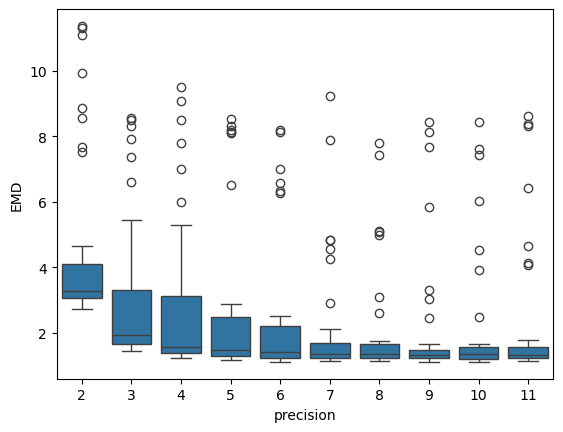

In [ ]:
sns.boxplot(data=emd_distribution_df, x='precision', y='EMD')

Let's discard the precision 2 due to high EMD

## Scientific Benchmark
TODO: box plot for each noise percentage and and number of bit flipped (waiting results)

In [7]:
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

In [10]:
def get_emd_with_noise(batch_size, learning_rate, precision, size, noise_type, percentage):
    '''
    Return the EMD achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/{size}_emd_{noise_type}_{percentage}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        if not emd_text.startswith('['):
            noise_emd = float(emd_text)
        else:
            emd = ast.literal_eval(emd_text)
            noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd

def get_emd_with_bitflip(batch_size, learning_rate, precision, size, number_bit):
    '''
    Return the EMD achieved by the Model with a certain number of bit flipped
    '''
    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/{size}_emd_bitflip_{number_bit}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        emd = ast.literal_eval(emd_text)
        noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd

### Bit flip Test

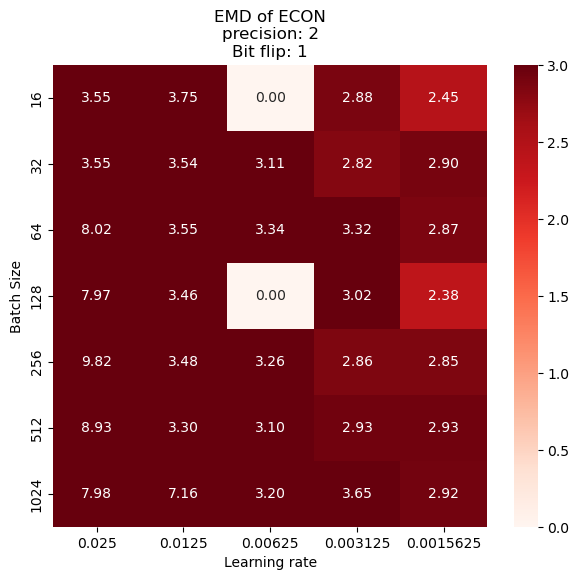

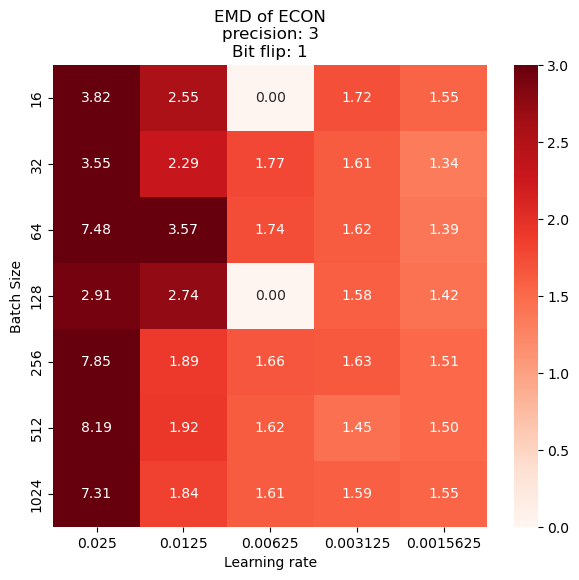

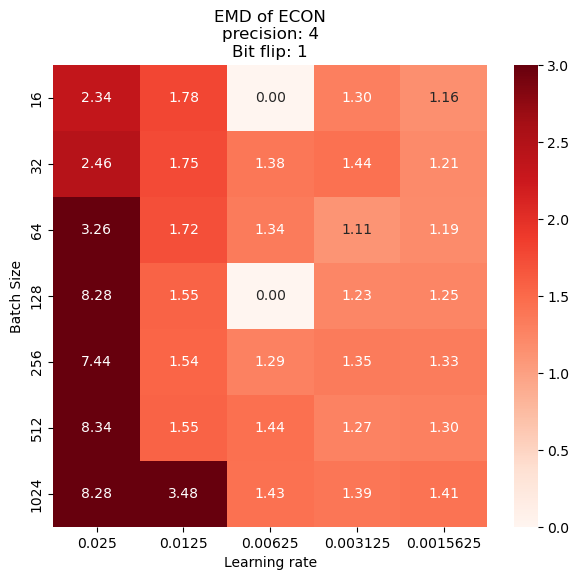

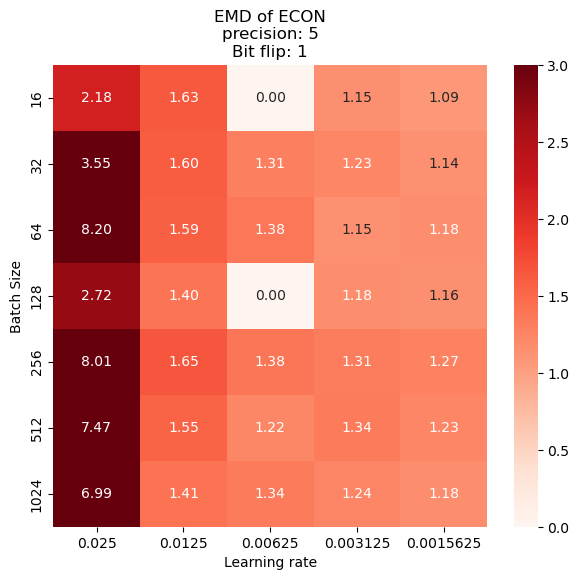

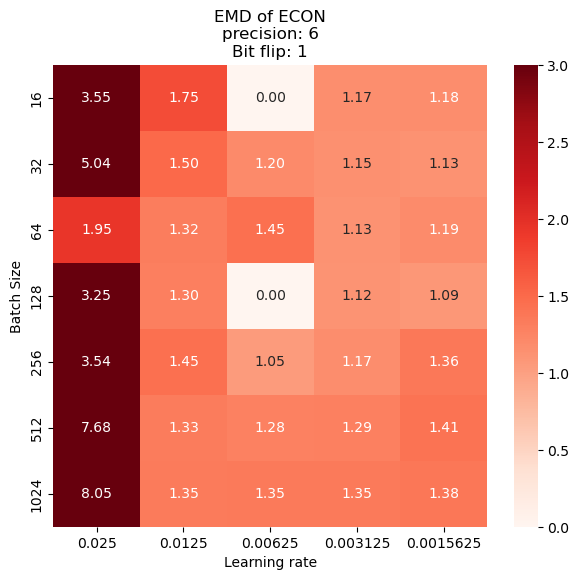

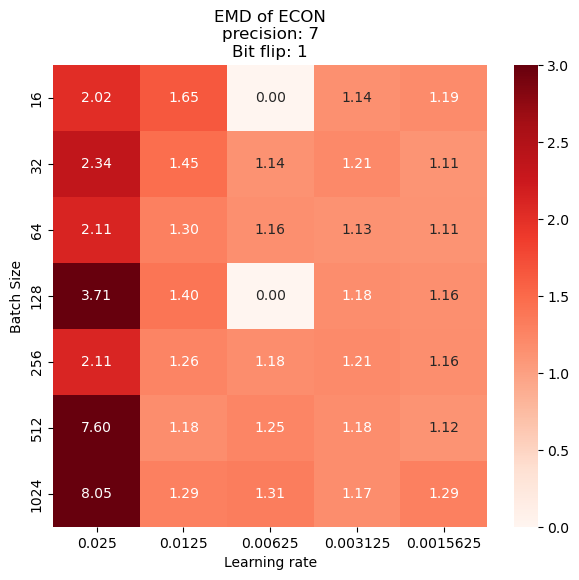

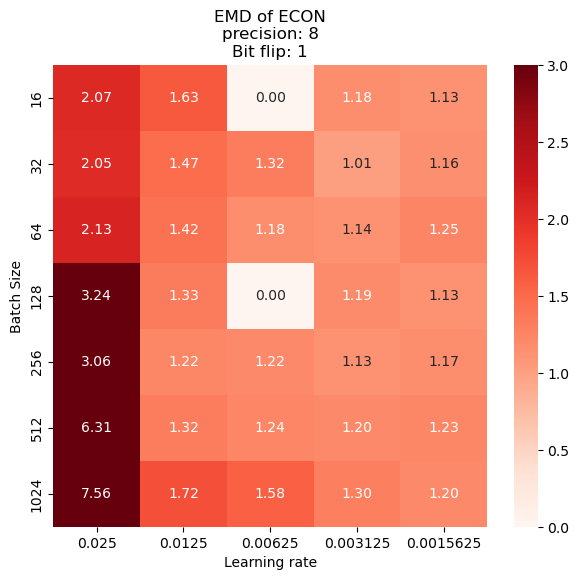

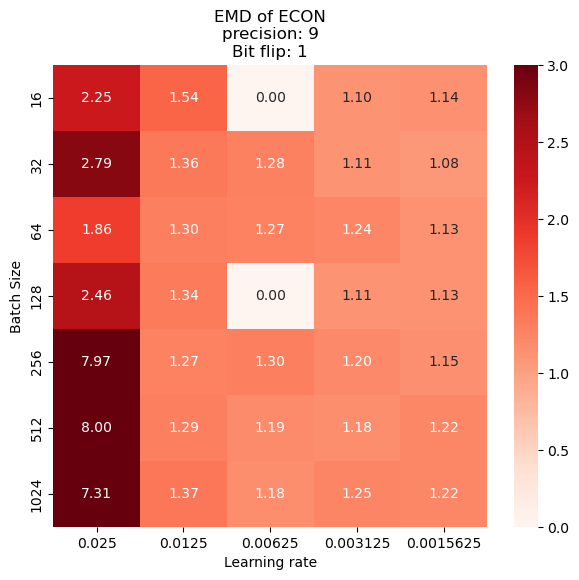

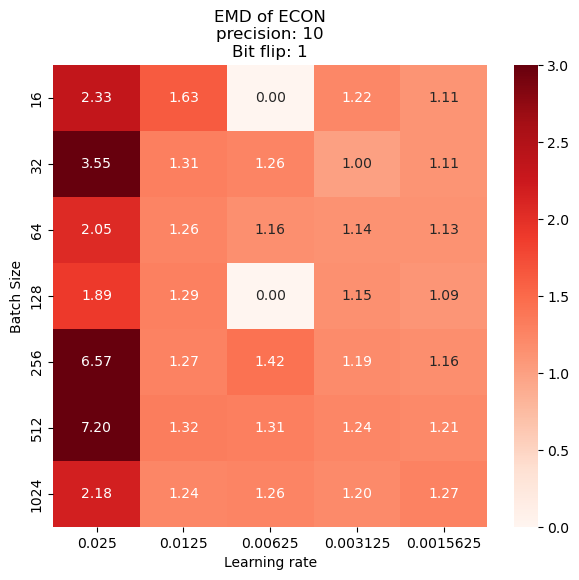

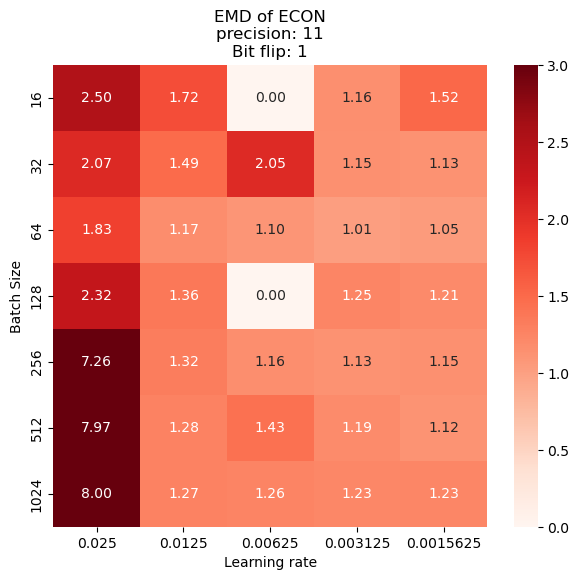

In [ ]:
emd_distribution = []
for p in precisions:
    emd_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            bitflip_emd_1 = get_emd_with_bitflip(bs, lr, p, size, 1)
            bitflip_emd_2 = get_emd_with_bitflip(bs, lr, p, size, 2)
            bitflip_emd_3 = get_emd_with_bitflip(bs, lr, p, size, 3)
            bitflip_emd_4 = get_emd_with_bitflip(bs, lr, p, size, 4)
            original_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
                        
            emd_matrix[x, y] = bitflip_emd_1
            
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_1,
                'type': '1 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_1) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_2,
                'type': '2 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_2) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_3,
                'type': '3 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_3) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_4,
                'type': '4 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_4) * 100 / original_emd,
                'original_emd': original_emd
            })
            
            
    # heat map of the accuracy with noise as input per precision
    emd_matrix = pd.DataFrame(emd_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(emd_matrix, 
                    f'EMD of ECON\nprecision: {p}\n' \
                    f'Bit flip: 1', 
                    (0, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
        
emd_distribution_df = pd.DataFrame(emd_distribution)

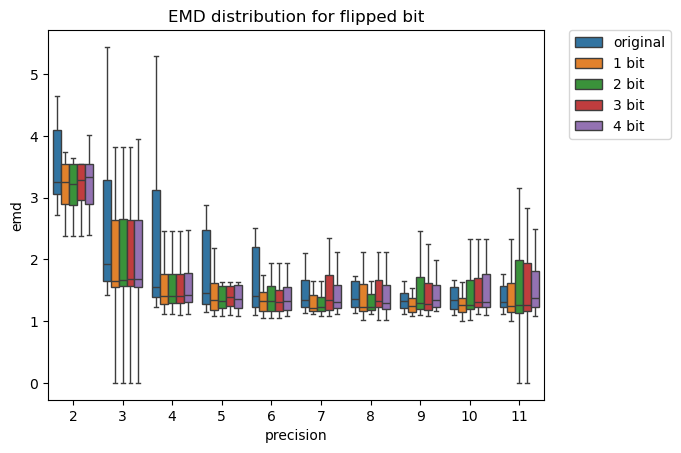

In [ ]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for flipped bit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### Noise test

In [19]:
MIN_EMD = 1.5
emd_distribution = []
robust_rank = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            noise_emd_5 = get_emd_with_noise(bs, lr, p, size, noise_type, 5)
            # noise_emd_25 = get_emd_with_noise(bs, lr, p, size, noise_type, 25)
            # noise_emd_50 = get_emd_with_noise(bs, lr, p, size, noise_type, 50)
            # noise_emd_75 = get_emd_with_noise(bs, lr, p, size, noise_type, 75)
            # noise_emd_100 = get_emd_with_noise(bs, lr, p, size, noise_type, 100)
            original_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = noise_emd_5
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - noise_emd_5) * 100 / original_emd,
                'original_emd': original_emd
            })
            # emd_distribution.append({
            #     'precision': p, 
            #     'emd': noise_emd_25,
            #     'type': '25'
            # })
            # emd_distribution.append({
            #     'precision': p, 
            #     'emd': noise_emd_50,
            #     'type': '50'
            # })
            # emd_distribution.append({
            #     'precision': p, 
            #     'emd': noise_emd_75,
            #     'type': '75'
            # })
            # emd_distribution.append({
            #     'precision': p, 
            #     'emd': noise_emd_100,
            #     'type': '100'
            # })
            
            
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    # plot_2d_heatmap(EMD_matrix, 
    #                 f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
    #                 f'Noise {noise_type} 5%', 
    #                 (1, 2.5),
    #                 'Learning rate',
    #                 'Batch Size',
    #                 'EMD')
        
emd_distribution_df = pd.DataFrame(emd_distribution)

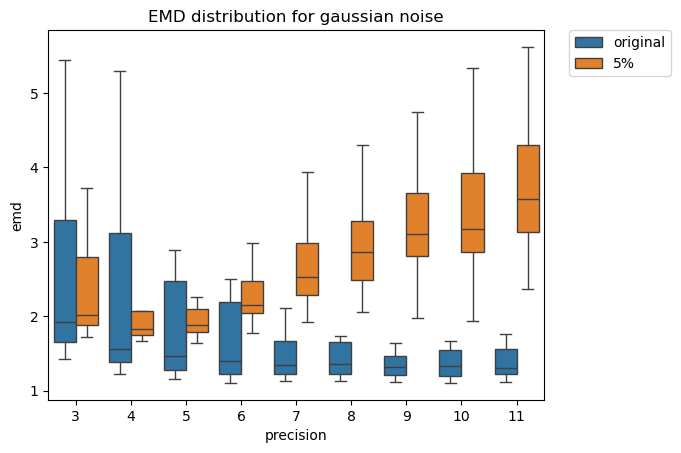

In [17]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

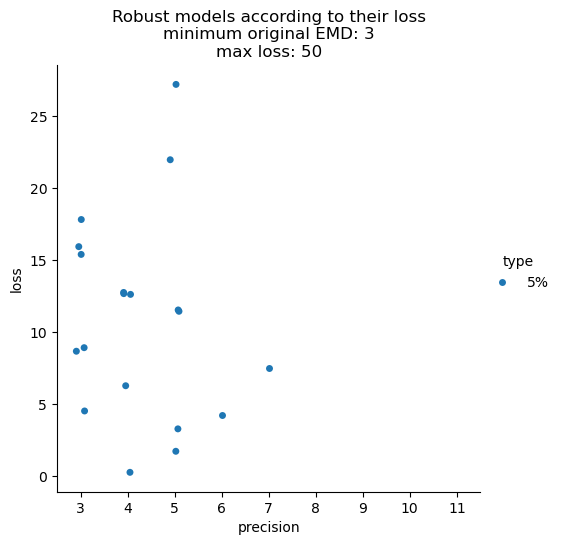

In [27]:
MAX_LOSS = 50
MAX_EMD = 3
# filter the entries 
robust_df = emd_distribution_df.sort_values(by=['loss', 'original_emd'], ascending=[True, False])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < 0) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_emd > MAX_EMD].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original EMD: {MAX_EMD}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

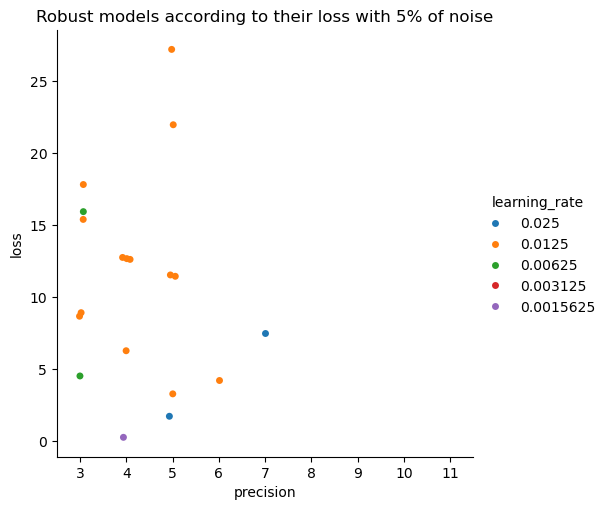

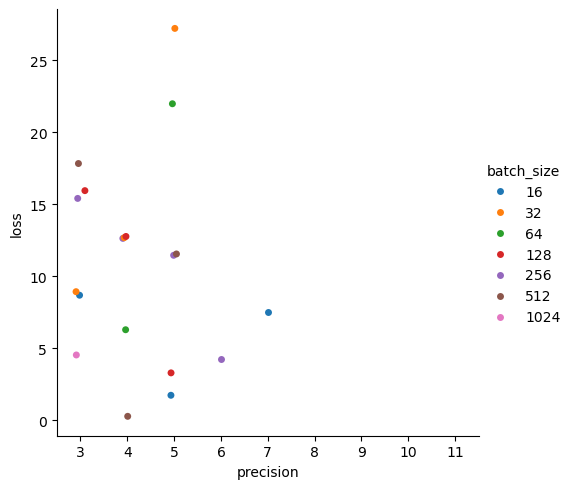

   original_emd       loss batch_size learning_rate precision
0      1.744381   0.256891        512     0.0015625         4
1      2.655157   1.718936         16         0.025         5
2      2.181461   3.275310        128        0.0125         5
3      2.143708   4.252361        256        0.0125         6
4      1.958069   4.518025       1024       0.00625         3
5      2.210208   6.270456         64        0.0125         4
6      2.917276   7.525187         16         0.025         7
7      2.931284   8.667431         16        0.0125         3
8      2.738463   8.913861         32        0.0125         3
9      2.234362  11.440973        256        0.0125         5
    original_emd       loss batch_size learning_rate precision
9       2.234362  11.440973        256        0.0125         5
10      2.285544  11.533723        512        0.0125         5
11      2.214235  12.615344        256        0.0125         4
12      2.375551  12.667472         32        0.0125         4
13 

IndexError: single positional indexer is out-of-bounds

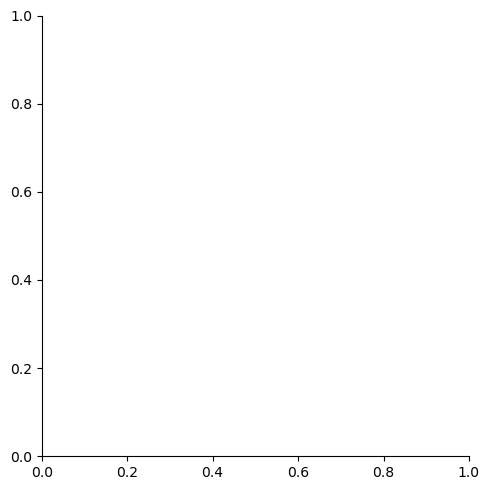

In [28]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].head(10))
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(10))

### NOTE
*small*:
By adding noise we observe a strange behavior, the EMD values are less spread but really high, with 25% of noise we already have too high values. Small precisions seems to handle noise better respect to high precision.
*baseline*
Same behavior of small

# Neural efficiency analysis

In [29]:
NE_DATA_DIR = "./ECON_ne"

def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision,
                          size, 
                          data_loader,
                          max_batches=None,
                          beta=-2):
    
    model, emd =load_model(batch_size, learning_rate, precision, size)
    metric = NeuralEfficiency(model, data_loader, performance=emd, max_batches=max_batches)
    
    return metric.compute(beta=beta)

In [30]:
ne_dataloader = get_data_module(1).test_dataloader()
ne_batch_num = None
robust_df.drop(robust_df[robust_df.type != '5%'].index, inplace=True)

In [33]:
ranking_robust = robust_df[
        ['precision', 'batch_size', 'learning_rate', 'original_emd', 'loss']
                            ].to_dict('records')

for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i
    
    print('-'*80)
    print('Low loss')
    ne = get_neural_efficiency(int(ranking_robust[best_index]['batch_size']),
                            float(ranking_robust[best_index]['learning_rate']), 
                            int(ranking_robust[best_index]['precision']),
                            size,
                            ne_dataloader,
                            max_batches=ne_batch_num)
    print(ne)

--------------------------------------------------------------------------------
Low loss
Computing the Neural efficiency...


/home/jovyan/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:108: UserWarning: Attention: the layer encoder.conv has tuple as features!
  warnings.warn(f"Attention: the layer " + name + " has tuple as features!")
/home/jovyan/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:104: UserWarning: Attention: the layer encoder.conv.conv has None features!
  warnings.warn(f"Attention: the layer " + name + " has None features!")


# CKA similarity anlysis

In [ ]:
CKA_DATA_DIR = "./ECON_cka_distances"

def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      size,
                      data_loader,
                      activation_layers,
                      max_batches=1000):
    model, _ = load_model(batch_size, learning_rate, precision, size)
    cka = CKA(model, 
              data_loader, 
              layers=activation_layers,
              name=f'{size}_bs{batch_size}_lr{learning_rate}_p{precision}',
              max_batches=max_batches)
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, size, load=True):
    # check if distance already computed
    if load:
        cka.name += f'_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(CKA_DATA_DIR):
            return cka.results
        
    model, _ = load_model(batch_size, learning_rate, precision, size)
    # look if the result has been already computed
    result = cka.compare(model, cka.layers)
    
    # store the result on file
    if not os.path.exists(CKA_DATA_DIR):
        os.mkdir(CKA_DATA_DIR)
        
    cka.save_on_file(path=CKA_DATA_DIR)
    return result



## Structural Analysis
This metric can be used to carry analysis about the internal structure of the model, indeed the CKA similarity is used in XAI field to try to understand the path learned by the model. We are going to use that to see the difference between extreme cases, for both good and bad models.

*Note*: Due to the architecture of ECON encoder we are only interested in the values on the diagonal of the heatmap, because it does not make sense to compare a Conv layer with a Dense layer.

In [ ]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
cka_datamodule = get_data_module(16)
cka_batch_num = 1000000
econ_layers = ['encoder.conv', 'encoder.enc_dense']
robust_df.drop(robust_df[robust_df.type != '5%'].index, inplace=True)

let's see the CKA similarity per layer of the robust models

CUDA available!


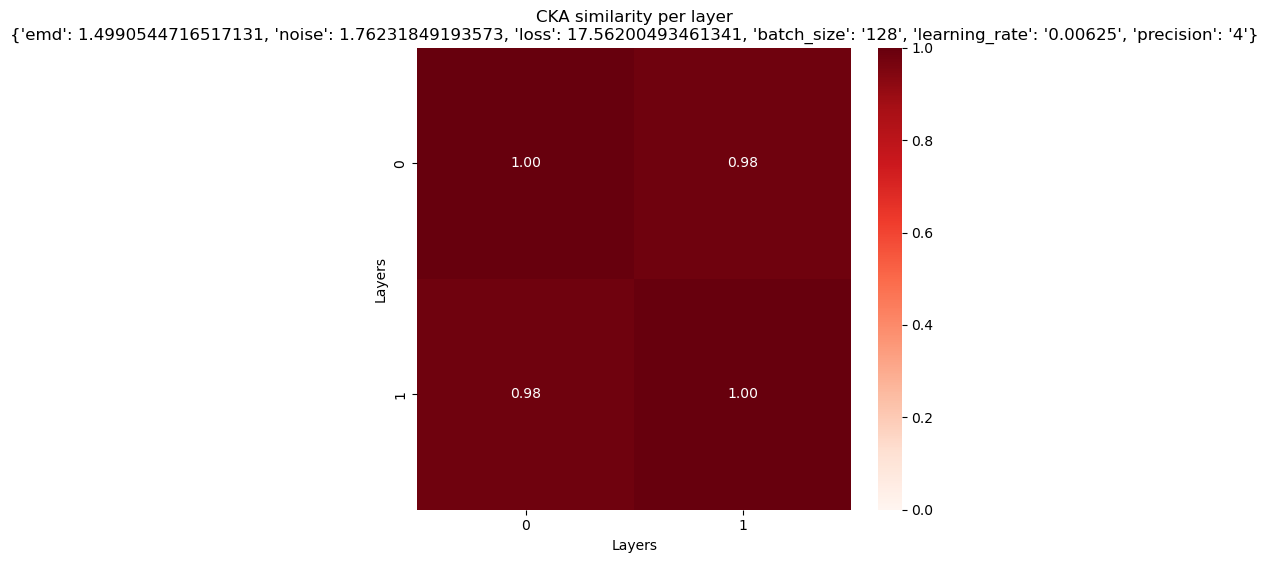

CUDA available!


KeyboardInterrupt: 

In [ ]:
for i in range(3):
    # i = -(i+1)    # last in the ranking
    cka = source_cka = get_cka_per_model(int(robust_rank[i]['batch_size']),
                                         float(robust_rank[i]['learning_rate']), 
                                         int(robust_rank[i]['precision']),
                                         size, 
                                         noisy_dataloader,
                                         econ_layers,
                                         cka_batch_num)

    results = cka.compute()
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{robust_rank[i]}", 
                    scale_label='CKA similarity')

Now let's compare different model:

CUDA available!
Storing the result...
Complete
0.022814571857452393


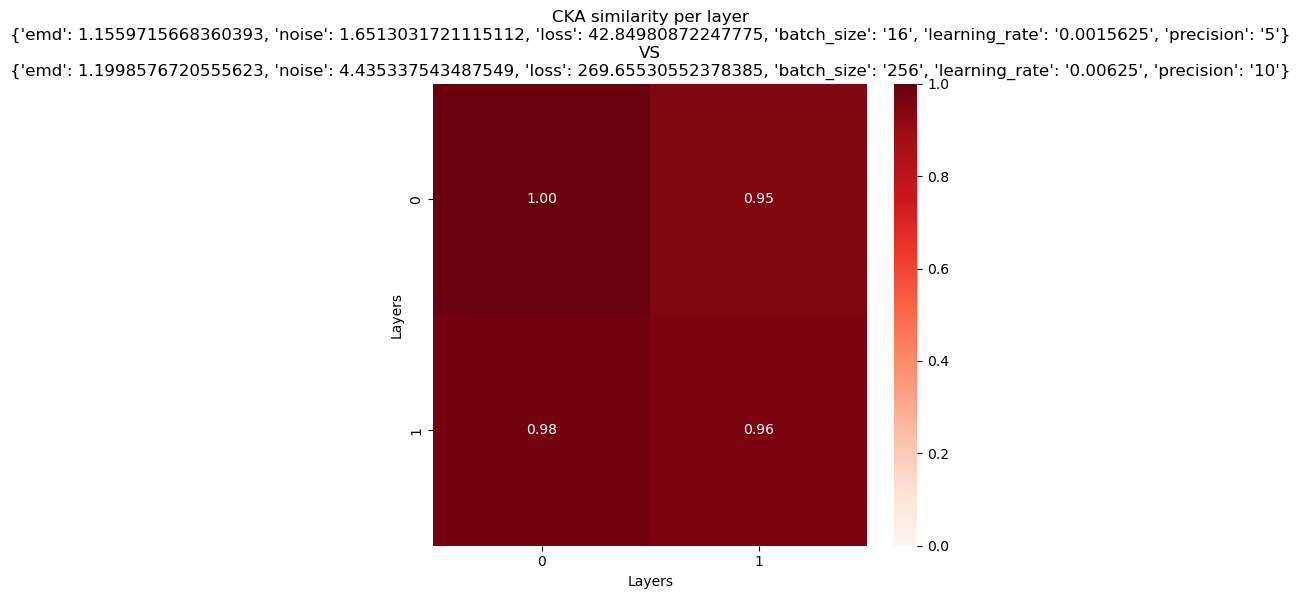

In [ ]:
cka = source_cka = get_cka_per_model(int(robust_rank[0]['batch_size']),
                                     float(robust_rank[0]['learning_rate']), 
                                     int(robust_rank[0]['precision']),
                                     size, 
                                     noisy_dataloader,
                                     econ_layers,
                                     cka_batch_num)

dist = compute_distance(cka,
                        int(robust_rank[-1]['batch_size']),
                        float(robust_rank[-1]['learning_rate']), 
                        int(robust_rank[-1]['precision']),
                        size, 
                        load=False)

print(dist['cka_dist'])
plot_2d_heatmap(dist['compared_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{robust_rank[0]}\nVS\n{robust_rank[-1]}", 
                    scale_label='CKA similarity')

### Convergence of the distance
we compute the same distance many times in order to understand the number of batch sizes required to have a correct value for our analysis.

In [ ]:
cka = source_cka = get_cka_per_model(batch_sizes[top_models[0]['model'][0]],
                                        learning_rates[top_models[0]['model'][1]], 
                                        top_models[0]['precision'],
                                        size, 
                                        cka_datamodule.test_dataloader(),
                                        econ_layers,
                                        1)

values = []
for num_batches in range(50, 100):
    cka.max_batches = num_batches
    dist = compute_distance(cka,
                            batch_sizes[last_models[i]['model'][0]],
                            learning_rates[last_models[i]['model'][1]], 
                            last_models[i]['precision'],
                            size,
                            load=False)
    print(dist['cka_dist'])
    values.append(dist['cka_dist'])

CUDA available!


KeyboardInterrupt: 

<AxesSubplot:>

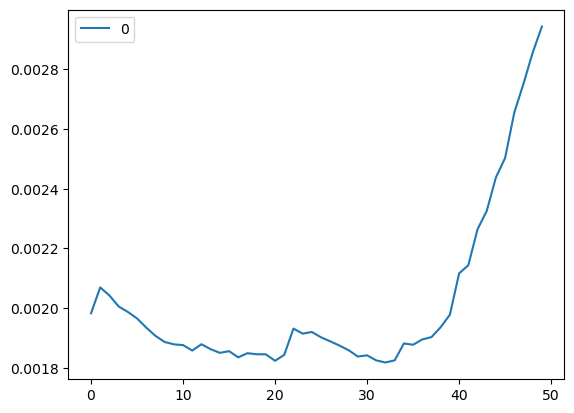

In [ ]:
df = pd.DataFrame(values)
sns.lineplot(df)

## Compare structure of the models

In [ ]:
for i in range(3):
    cka = source_cka = get_cka_per_model(batch_sizes[top_models[i]['model'][0]],
                                        learning_rates[top_models[i]['model'][1]], 
                                        top_models[i]['precision'],
                                        size, 
                                        cka_datamodule.test_dataloader(),
                                        econ_layers,
                                        cka_batch_num)

    result = cka.compute()
    plot_2d_heatmap(result['internal_cka'], f"Best model CKA similarity\nEMD: {top_models[i]['EMD']}", scale_label='CKA similarity')

CUDA available!


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 700x600 with 0 Axes>

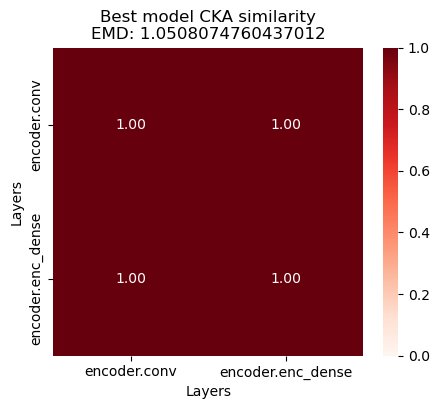

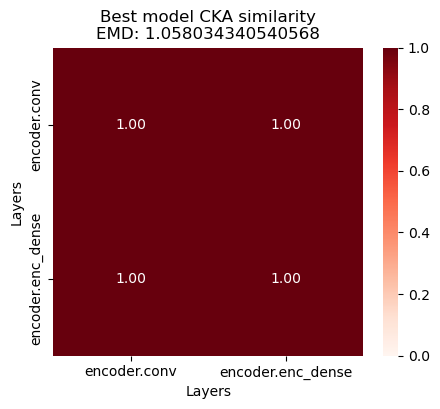

In [ ]:
for i in range(3):
    cka = source_cka = get_cka_per_model(batch_sizes[last_models[i]['model'][0]],
                                         learning_rates[last_models[i]['model'][1]], 
                                         last_models[i]['precision'],
                                         size, 
                                         cka_datamodule.test_dataloader(),
                                         econ_layers,
                                         cka_batch_num)

    cka.compute()
    plot_2d_heatmap(result['internal_cka'], f"Best model CKA similarity\nEMD: {top_models[i]['EMD']}", scale_label='CKA similarity')

In [ ]:
# perform dimensionality reduction (PCA or t-SNE)
embedding = PCA(n_components=2).fit_transform(distances_matrix)
# embedding = TSNE(n_components=2).fit_transform(distances)
# plot the scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1])

# Annotate points with model index
for index, model in enumerate(top_models):
    plt.annotate(f'{index}', (embedding[index, 0], embedding[index, 1]))
    
plt.title('Model Distances')
plt.show()

NameError: name 'distances_matrix' is not defined

### Compare the structure of the worst models

### Best vs Worst models

## Compare different models
Let's try to compare different models one against the other. The idea is that, if we consider the CKA similarity as a distance among models, we will have that models with similar architecture. The scope of this analysis is to verify if good models are closer one to each other and then see what change if we start to add different percentages of noise.

## Compare the real EMD without the flags of the empty matrix
During the studies of the loss landscape, we discover a strange case in the test of the ECON model. The Econ model is an autoencoder used to compress the information coming from signals that are encoded in a sort of matrix. To evaluate the model we should use the EMD but it is not differentiable, so it is used only as test and the training and evaluation of the model is done with an approximate EMD loss function called Telescope.

Looking at the models with big batch sizes (ex. 512 or 1024) we achieved negative EMD values during the test of the model, but it should not be possible (EMD >= 0). Looking at the implementation of the model we found in the computation of the real EMD thi flag, where if the output of the Encoder is zero set the emd as -0.5 which bias the final average EMD of the model, which in most of the case is actually really high.

<div style="text-align:center">
    <img src="images/EMD_flag.png"></img>
</div>



In [ ]:
def print_old_EMD(size, precision, bs, lr):
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    for exp in range(1, 3):
        file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                print("AVG EMD: ", content)

        except Exception as e:
            continue


for lr in learning_rate:              
    print_old_EMD('small', 8, 1024, lr)

NameError: name 'learning_rate' is not defined

In [ ]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_real_EMD(size, precision, bs, lr):
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader())
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    print("AVG EMD: ", avg_emd)
    


compute_real_EMD('small', 8, 1024, 0.1)
print_old_EMD('small', 8, 1024, 0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)
Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 341/341 [02:08<00:00,  2.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            13.577227592468262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 13.577227592468262}]
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': -0.19799108803272247}]
AVG EMD:  [{'AVG_EMD': -0.5}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.05)
print_old_EMD('small', 8, 1024, 0.05)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [02:26<00:00,  2.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD             9.190462112426758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 9.190462112426758}]
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 6.228666305541992}]
AVG EMD:  [{'AVG_EMD': 7.037817478179932}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0125)
print_old_EMD('small', 8, 1024, 0.0125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:28<00:00,  1.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.1153733730316162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153733730316162}]
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153912544250488}]
AVG EMD:  [{'AVG_EMD': 1.1363208293914795}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.00625)
print_old_EMD('small', 8, 1024, 0.00625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:29<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2486552000045776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486552000045776}]
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486635446548462}]
AVG EMD:  [{'AVG_EMD': 1.254514455795288}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.003125)
print_old_EMD('small', 8, 1024, 0.003125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:25<00:00,  1.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2884447574615479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2884447574615479}]
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2883154153823853}]
AVG EMD:  [{'AVG_EMD': 1.318579077720642}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0015625)
print_old_EMD('small', 8, 1024, 0.0015625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:31<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2459907531738281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2459907531738281}]
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2461320161819458}]
AVG EMD:  [{'AVG_EMD': 1.3005080223083496}]


As we can see from those results, negative values of EMD corresponds to really high values of EMD. I assume that when the model have to deal with large batch size and learning rates it has to process really big and sparse matrix which it just compress as Zero-matrices ignoring all the signals with low intensity. This could not be a problem since we are aware of it, especially because this event is not detected by the telescope loss function which returns good value of EMD. 